# Notes

**BINARY CLASSIFICATION**  
**Input data:** vectors  
**Labels:** scalars (1s, 0s)  
**Amount of data:** Lots  
* 2x `Dense(16, activation='relu')`  
* 1x `Dense(1, activation='sigmoid')`  
* `optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy')`
* Validation phase: `epochs=20, batch_size=512, validation_data=(x_val, y_val)`
    * `x_val = x_train[:10000]`
    * `partial_x_train = x_train[10000:]`
    * `y_val = y_train[:10000]`
    * `partial_y_train = y_train[10000:]`

**MULTICLASS CLASSIFICATION**  
**Input data:** vectors  
**Labels:** vectors (1s, 0s) dim 46 (one-hot)  
**Amount of data:** Lots  
* 2x `Dense(64, activation='relu')` ($64>46$ avoids bottleneck)  
* 1x `Dense(46, activation='softmax')`  
* `optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy')`  
**OR** `loss='sparse_categorical_crossentropy` if cast labels as an integer tensor
* Validation phase: `epochs=20, batch_size=512, validation_data=(x_val, y_val)`
    * `x_val = x_train[:10000]`
    * `partial_x_train = x_train[10000:]`
    * `y_val = one_hot_train_labels[:1000]`
    * `partial_y_train = one_hot_train_labels[1000:]`

**SCALAR REGRESSION**  
**Input data:** vectors  
**Labels:** scalars ($\mathbb{R}$)  
**Amount of data:** Little ($\therefore$ K-fold)  
* 2x `Dense(64, activation='relu')`  
* 1x `Dense(1)`  
* `optimizer="rmsprop", loss="mse", metrics=["mae"])`
* Validation phase: `epochs=20, batch_size=512, validation_data=(x_val, y_val)`
    * `x_val = x_train[:10000]`
    * `partial_x_train = x_train[10000:]`
    * `y_val = one_hot_train_labels[:1000]`
    * `partial_y_train = one_hot_train_labels[1000:]`

# Intro Examples

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## MNIST

### Data

In [2]:
from keras.datasets import mnist

In [3]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [4]:
print(train_images.shape, train_labels)

print(train_images.shape, test_labels)

(60000, 28, 28) [5 0 4 ... 5 6 8]
(60000, 28, 28) [7 2 1 ... 4 5 6]


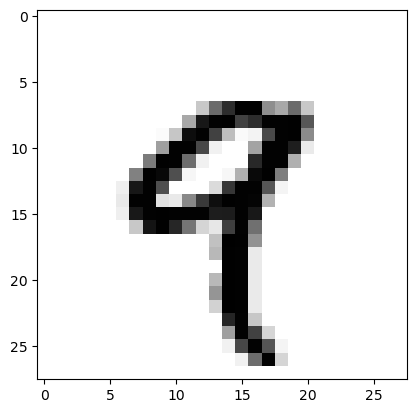

In [5]:
digit = train_images[4]

plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

### Network architecture

In [6]:
from keras import layers, models

In [7]:
network = models.Sequential()
network.add(layers.Dense(512, activation="relu", input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation="softmax"))

### Compilation step

In [8]:
network.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)

### Prepare image data

In [9]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

print(train_images.shape, train_labels)

print(train_images.shape, test_labels)

(60000, 784) [5 0 4 ... 5 6 8]
(60000, 784) [7 2 1 ... 4 5 6]


### Prepare labels data

In [10]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

### Train model

In [11]:
network.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 2s 4ms/step - loss: 0.2670 - accuracy: 0.9232
Epoch 2/5
469/469 [==============================] - 2s 5ms/step - loss: 0.1075 - accuracy: 0.9685
Epoch 3/5
469/469 [==============================] - 2s 4ms/step - loss: 0.0715 - accuracy: 0.9790
Epoch 4/5
469/469 [==============================] - 2s 4ms/step - loss: 0.0514 - accuracy: 0.9850
Epoch 5/5
469/469 [==============================] - 2s 4ms/step - loss: 0.0386 - accuracy: 0.9884


In [12]:
test_loss, test_acc = network.evaluate(test_images, test_labels)
print("test_acc:", test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.0741 - accuracy: 0.9760
test_acc: 0.9760000109672546


## Classifying movie reviews: binary classification

### Imports

In [76]:
from keras.datasets import imdb

### IMBD dataset

In [14]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [16]:
print("train and test labels shape: ", train_labels.shape, test_labels.shape)
print("Review 1 length: ", len(train_data[0]))
print("Review 2 length: ", len(train_data[1]))
print("Review 3 length: ", len(train_data[2]))
print("Max word: ", max([max(sequence) for sequence in train_data]))

train and test labels shape:  (25000,) (25000,)
Review 1 length:  218
Review 2 length:  189
Review 3 length:  141
Max word:  9999


In [20]:
def decode_review(index):
    word_index = imdb.get_word_index()
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
    decoded_review = " ".join(
        [reverse_word_index.get(i - 3, "?") for i in train_data[index]]
    )
    return decoded_review

In [21]:
decode_review(0)

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

### Preparing the data

Turn lists of integers into tensors.

In [108]:
##  One-hot encode
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.0
    return results


x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [24]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.])

Vectorise labels.  
(I don't think `np.asarray()` is required as both are already np arrays.)

In [27]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

### Building the network

In [30]:
from keras import layers, models

model = models.Sequential()
model.add(layers.Dense(16, activation="relu", input_shape=(10000,)))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

In [32]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

Alternative (configure optimizer & using custom losses and metrics):  
`from keras import losses
from keras import metrics
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
loss=losses.binary_crossentropy,
metrics=[metrics.binary_accuracy])`

### Validating the approach

In [33]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

### Train

In [34]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val),
)

Epoch 1/20
30/30 [==============================] - 1s 29ms/step - loss: 0.5395 - accuracy: 0.7743 - val_loss: 0.4083 - val_accuracy: 0.8620
Epoch 2/20
30/30 [==============================] - 0s 13ms/step - loss: 0.3334 - accuracy: 0.8921 - val_loss: 0.3136 - val_accuracy: 0.8837
Epoch 3/20
30/30 [==============================] - 0s 12ms/step - loss: 0.2475 - accuracy: 0.9157 - val_loss: 0.2852 - val_accuracy: 0.8887
Epoch 4/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1980 - accuracy: 0.9359 - val_loss: 0.2766 - val_accuracy: 0.8895
Epoch 5/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1672 - accuracy: 0.9428 - val_loss: 0.2898 - val_accuracy: 0.8858
Epoch 6/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1383 - accuracy: 0.9553 - val_loss: 0.2873 - val_accuracy: 0.8840
Epoch 7/20
30/30 [==============================] - 0s 11ms/step - loss: 0.1197 - accuracy: 0.9628 - val_loss: 0.3206 - val_accuracy: 0.8743
Epoch 8/20
30

In [37]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### Plot training and validation loss

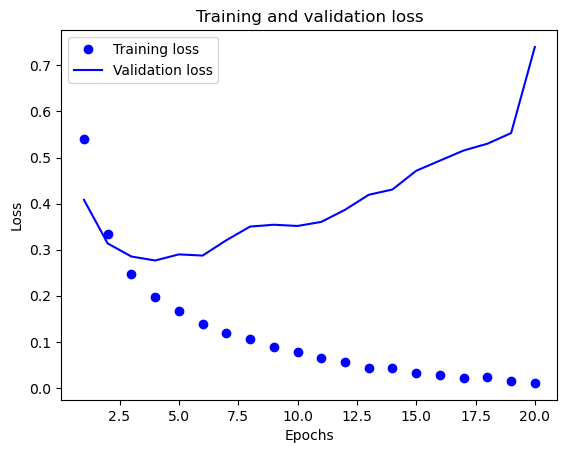

In [43]:
loss = history_dict["loss"]  # (train data) loss val for each epoch
val_loss = history_dict["val_loss"]  # (val data) loss val for each epoch

epochs = range(1, 21)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

### Plot training and validation accuracy

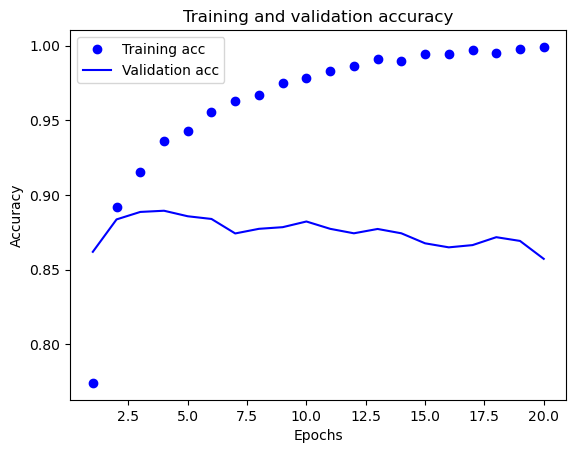

In [49]:
acc_values = history_dict["accuracy"]
val_acc_values = history_dict["val_accuracy"]

plt.plot(epochs, acc_values, "bo", label="Training acc")
plt.plot(epochs, val_acc_values, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### Retraining the model using all training data

In [72]:
model = models.Sequential()
model.add(layers.Dense(16, activation="relu", input_shape=(10000,)))
model.add(layers.Dense(16, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 1s 7ms/step - loss: 0.5277 - accuracy: 0.7769
Epoch 2/4
49/49 [==============================] - 0s 7ms/step - loss: 0.3105 - accuracy: 0.8938
Epoch 3/4
49/49 [==============================] - 0s 7ms/step - loss: 0.2308 - accuracy: 0.9188
Epoch 4/4
782/782 [==============================] - 1s 1ms/step - loss: 0.2831 - accuracy: 0.8876


In [75]:
print("loss: ", results[0])
print("accuracy: ", results[1])

[0.2830660045146942, 0.8876000046730042]

### Generating predictions on new data

In [163]:
predictions = model.predict(x_test)

71/71 [==============================] - 0s 2ms/step


## Classifying newswires: a multiclass classification example

### Imports

In [77]:
from keras.datasets import reuters

### Reuters dataset

In [118]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000
)

In [119]:
print(len(train_data))
print(len(test_data))
print(train_data[10])

8982
2246
[1, 245, 273, 207, 156, 53, 74, 160, 26, 14, 46, 296, 26, 39, 74, 2979, 3554, 14, 46, 4689, 4329, 86, 61, 3499, 4795, 14, 61, 451, 4329, 17, 12]


In [120]:
def decode_newswire(index):
    word_index = reuters.get_word_index()
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
    decoded_newswire = " ".join(
        [reverse_word_index.get(i - 3, "?") for i in train_data[index]]
    )
    return decoded_newswire

In [121]:
decode_newswire(0)

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

### Preparing the data

In [134]:
len(train_data)

8982

In [135]:
len(train_labels)

8982

In [138]:
len(x_train)

8982

In [137]:
## One-hot encode
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [123]:
print(x_train[10])

[0. 1. 0. ... 0. 0. 0.]


In [146]:
## Categorical encoding
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.0
    return results


one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)
print(len(one_hot_train_labels))

8982


Equaivalent in built into Keras:  
`from keras.utils.np_utils import to_categorical`

`one_hot_train_labels = to_categorical(train_labels)`  
`one_hot_test_labels = to_categorical(test_labels)`

### Building the network

In [125]:
model = models.Sequential()
model.add(layers.Dense(64, activation="relu", input_shape=(10000,)))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(46, activation="softmax"))

In [126]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)

### Validating the approach

In [150]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [154]:
print(len(x_train))
print(len(one_hot_train_labels))

print(len(partial_x_train))
print(len(partial_y_train))

8982
8982
7982
7982


### Train

In [155]:
history = model.fit(
    partial_x_train,
    partial_y_train,
    epochs=20,
    batch_size=512,
    validation_data=(x_val, y_val),
)

Epoch 1/20
16/16 [==============================] - 1s 24ms/step - loss: 2.6713 - accuracy: 0.5192 - val_loss: 1.7697 - val_accuracy: 0.6210
Epoch 2/20
16/16 [==============================] - 0s 20ms/step - loss: 1.4945 - accuracy: 0.6802 - val_loss: 1.3526 - val_accuracy: 0.7040
Epoch 3/20
16/16 [==============================] - 0s 19ms/step - loss: 1.1554 - accuracy: 0.7536 - val_loss: 1.2015 - val_accuracy: 0.7310
Epoch 4/20
16/16 [==============================] - 0s 19ms/step - loss: 0.9485 - accuracy: 0.7969 - val_loss: 1.0804 - val_accuracy: 0.7620
Epoch 5/20
16/16 [==============================] - 0s 17ms/step - loss: 0.7868 - accuracy: 0.8314 - val_loss: 1.0077 - val_accuracy: 0.7780
Epoch 6/20
16/16 [==============================] - 0s 16ms/step - loss: 0.6585 - accuracy: 0.8592 - val_loss: 0.9385 - val_accuracy: 0.7930
Epoch 7/20
16/16 [==============================] - 0s 16ms/step - loss: 0.5450 - accuracy: 0.8841 - val_loss: 0.9110 - val_accuracy: 0.7980
Epoch 8/20
16

### Plot training and validation loss

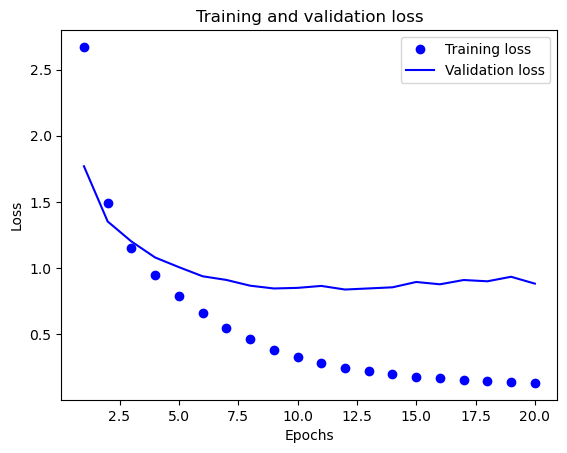

In [157]:
loss = history.history["loss"]  # (train data) loss val for each epoch
val_loss = history.history["val_loss"]  # (val data) loss val for each epoch

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Plot training and validation accuracy

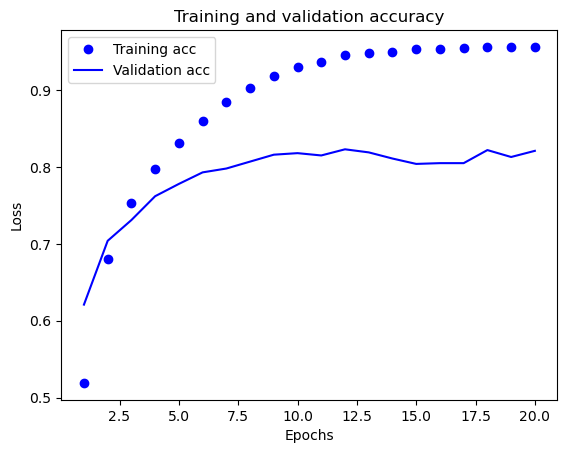

In [159]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Retraining the model using all training data

In [160]:
model = models.Sequential()
model.add(layers.Dense(64, activation="relu", input_shape=(10000,)))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(46, activation="softmax"))

model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)

model.fit(
    partial_x_train,
    partial_y_train,
    epochs=9,
    batch_size=512,
    validation_data=(x_val, y_val),
)

results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 25ms/step - loss: 2.8358 - accuracy: 0.4886 - val_loss: 1.8807 - val_accuracy: 0.5970
Epoch 2/9
16/16 [==============================] - 0s 17ms/step - loss: 1.5856 - accuracy: 0.6673 - val_loss: 1.4043 - val_accuracy: 0.6860
Epoch 3/9
16/16 [==============================] - 0s 17ms/step - loss: 1.2205 - accuracy: 0.7335 - val_loss: 1.2242 - val_accuracy: 0.7270
Epoch 4/9
16/16 [==============================] - 0s 16ms/step - loss: 1.0132 - accuracy: 0.7804 - val_loss: 1.1114 - val_accuracy: 0.7490
Epoch 5/9
16/16 [==============================] - 0s 16ms/step - loss: 0.8462 - accuracy: 0.8203 - val_loss: 1.0619 - val_accuracy: 0.7710
Epoch 6/9
16/16 [==============================] - 0s 16ms/step - loss: 0.7114 - accuracy: 0.8493 - val_loss: 1.0063 - val_accuracy: 0.7850
Epoch 7/9
16/16 [==============================] - 0s 17ms/step - loss: 0.6009 - accuracy: 0.8762 - val_loss: 0.9219 - val_accuracy: 0.8050
Epoch 8/9
16/16 [===

In [162]:
print("loss: ", results[0])
print("accuracy: ", results[1])

loss:  0.9717589020729065
accuracy:  0.7862867116928101


### Generating predictions on new data

In [163]:
predictions = model.predict(x_test)

71/71 [==============================] - 0s 2ms/step


In [168]:
print(
    f"prediction vector length: {predictions[0].shape}",
    f"sum of predictions across categories: {np.sum(predictions[0])}",
    f"class with highest probability: {np.argmax(predictions[0])}",
    sep="\n",
)

prediction vector length: (46,)
sum of predictions across categories: 0.9999999403953552
class with highest probability: 3


## Predicting house prices: a regression example

### Imports

In [169]:
from keras.datasets import boston_housing

### Boston housing dataset

In [170]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


In [173]:
print(len(train_data))
print(len(test_data))

print(train_data[10])
print(test_data[10])

404
102
[  9.59571   0.       18.1       0.        0.693     6.404   100.
   1.639    24.      666.       20.2     376.11     20.31   ]
[2.2876e-01 0.0000e+00 8.5600e+00 0.0000e+00 5.2000e-01 6.4050e+00
 8.5400e+01 2.7147e+00 5.0000e+00 3.8400e+02 2.0900e+01 7.0800e+01
 1.0630e+01]


### Preparing the data

In [175]:
## Normalising (mean = 0, std = 1)
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

print(train_data[10])
print(test_data[10])

[ 0.63391647 -0.48361547  1.0283258  -0.25683275  1.15788777  0.19313958
  1.11048828 -1.03628262  1.67588577  1.5652875   0.78447637  0.22689422
  1.04466491]
[-0.380999   -0.48361547 -0.37402299 -0.25683275 -0.31887859  0.1945502
  0.58730449 -0.50578021 -0.51114231 -0.13178499  1.10299743 -3.02127105
 -0.29132553]


### Building the network

In [177]:
## Create function this time!


def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation="relu", input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(1))
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

### Validating the approach (K-fold validation)

In [182]:
## 100 epochs
k = 4
num_val_samples = len(train_data) // k

num_epochs = 100
all_scores = []


for i in range(k):
    print("processing fold #", i)

    # Prepares the validation data: data from partition #k
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]

    # Prepares the training data: data from all other partition
    partial_train_data = np.concatenate(
        [train_data[: i * num_val_samples],
         train_data[(i + 1) * num_val_samples :]],
        axis=0,
    )
    partial_train_targets = np.concatenate(
        [train_targets[: i * num_val_samples],
         train_targets[(i + 1) * num_val_samples :]],
        axis=0,
    )

    # Builds the Keras model (already compiled)
    model = build_model()
    model.fit(
        partial_train_data,
        partial_train_targets,
        epochs=num_epochs,
        batch_size=1,
        verbose=0,
    )

    # Evaluates the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [185]:
print(all_scores)
print("Mean: ", np.mean(all_scores))

[2.063267230987549, 2.98335862159729, 2.873342752456665, 2.387071371078491]
Mean:  2.576759994029999


In [201]:
## 500 epochs and save the validation logs at each fold
k = 4
num_val_samples = len(train_data) // k

num_epochs = 500
all_mae_histories = []


for i in range(k):
    print("processing fold #", i)

    # Prepares the validation data: data from partition #k
    val_data = train_data[i * num_val_samples : (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples : (i + 1) * num_val_samples]

    # Prepares the training data: data from all other partition
    partial_train_data = np.concatenate(
        [train_data[: i * num_val_samples],
         train_data[(i + 1) * num_val_samples :]],
        axis=0,
    )
    partial_train_targets = np.concatenate(
        [train_targets[: i * num_val_samples],
         train_targets[(i + 1) * num_val_samples :]],
        axis=0,
    )

    # Builds the Keras model (already compiled)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets), # evaluation now included in fit
                        epochs=num_epochs, batch_size=1, verbose=0)

    # Extract val_mean_absolute_error
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [200]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

In [202]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

print(len(all_mae_histories[0]))
print(average_mae_history[0])

500
4.677147626876831


### Plot validation loss (mae)

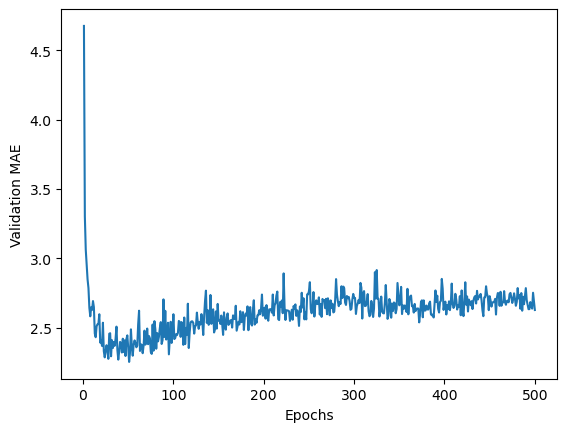

In [203]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

It may be a little difficult to see the plot, due to scaling issues and relatively high variance.  
We do the following:
* Omit the first 10 data points, which are on a different scale than the rest of the curve.
* Replace each point with an exponential moving average of the previous points, to obtain a smooth curve.

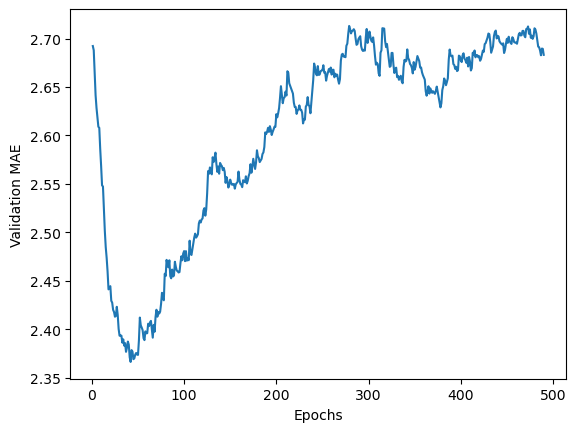

In [204]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

### Train final model

In [223]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=50, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 19.0299 - mae: 2.7086


In [224]:
test_mae_score

2.708568572998047

# Fundamentals of machine learning

## Validation methods

* Simple hold-out validation
* K-fold cross-validation  
    - little data
* Iterated K-fold validation with shuffling  
    - little data available and you need to evaluate your model as precisely as possible

## Things to keep in mind

*  Data representativeness
*  The arrow of time
*  Redundancy in your data

## Data Preprocessing

* Vectorisation
* Value normalisation
* Handling missing values
* Feature engineering

## Overfitting and underfitting

* Get more training data
* Reduce the capacity of the network
* Add weight regularisation
    - L1
    - L2
    - L1 and L2
* Add dropout

##  The universal workflow of machine learning